In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.optimize import curve_fit

In [2]:
# Read in the data
df = pd.read_csv("./data/wholetime.csv")

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/113245504.py:2: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/wholetime.csv")


In [3]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [16]:
df_covid = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2021-03-01')].dropna()
df_covid = df_covid[(df_covid['started_at'] < '2020-11-01') | (df_covid['started_at'] >= '2020-12-01')]

In [17]:
df_covid_nm = return_nm(df_covid)

In [18]:
df_n = df_covid_nm[0]
df_m = df_covid_nm[1]

In [19]:
"""
Kobayashi & Génois (2021)のモデルを用いて、計算する
"""
def model1(m, m0, kappa):
    Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
    if res.any() < 0:
        return 0
    else:
        return res
    
def model2(m, m0, Np):
    kappa = 8*m0/(Np**2-Np)
    res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
    if res.any() < 0:
        return 0
    else:
        return res
    
def calc_N(Np, kappa):
    return Np * (1 - (2 / (kappa * Np))*(1 - (1 - (kappa / 2))**Np))

def calc_M(Np, kappa):
    return (kappa * Np * (Np - 1)) / 8

In [84]:
init_m0_range = [1, 1000]
init_kappa_range = [0.001, 1.5]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, df_m, df_n, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = df_n - model1(df_m, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

[4.97213411e+03 1.57929673e-01]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/4113075532.py:6: RuntimeWarning: invalid value encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/4113075532.py:5: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2


In [85]:
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [1, 40000]
init_Np_range = [1, 10000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = curve_fit(model1, df_m, df_n, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = df_n - model2(df_m, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[10761.17510661   561.70101451]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/4113075532.py:6: RuntimeWarning: invalid value encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/4113075532.py:14: RuntimeWarning: invalid value encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))


In [86]:
N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,df_m,df_n,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(df_m)):
    Np.append((1+np.sqrt(1+32*df_m[i]/kappa))/2)


for i in range(len(df_n)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(df_m)):
    M_fit.append(calc_M(Np[i], kappa))

N_fit2 = []
M_fit2 = []
popt2, pcov2 = curve_fit(model2, df_m, df_n, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(df_m)):
    kappa2.append(8*df_m[i]/(Np2**2-Np2))

for i in range(len(df_n)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(df_m)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model1:  [4.97213411e+03 1.57929673e-01]
model2:  [1349.99567904  544.49768425]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/4113075532.py:6: RuntimeWarning: overflow encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/4113075532.py:5: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_2873/4113075532.py:14: RuntimeWarning: overflow encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))


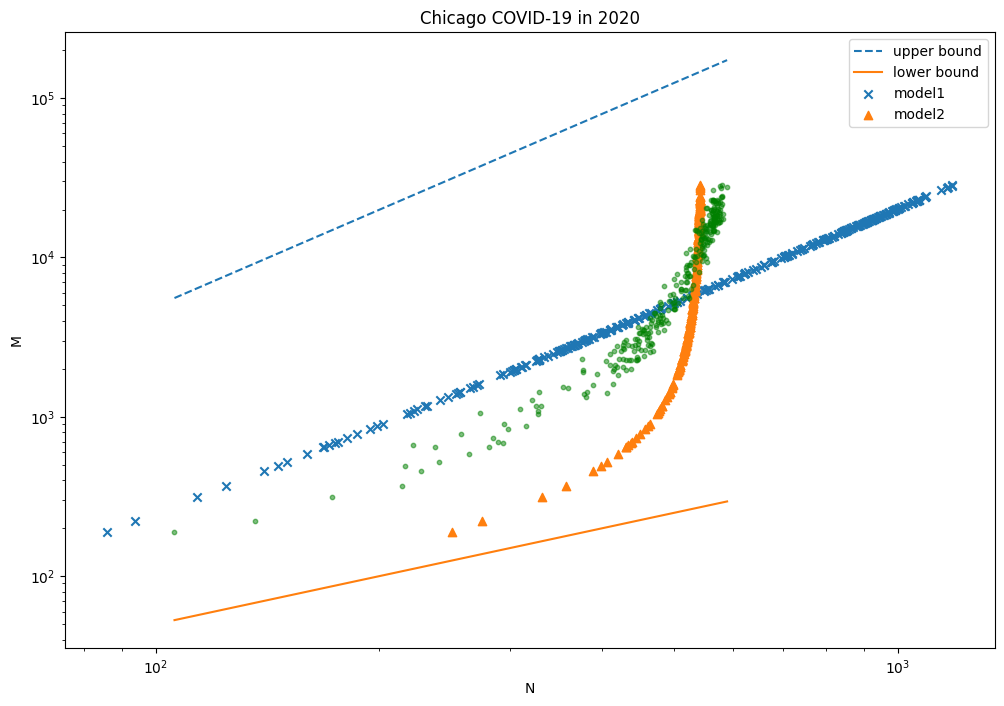

In [88]:
# plot 
nn = len(df_n)
xmin = min(df_n)
xmax = max(df_n)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(12, 8))
plt.plot(p, upper_bound, "--", label='upper bound')
plt.plot(p, lower_bound, "-", label='lower bound')
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.scatter(df_n, df_m, s=10, c='green', alpha=0.5)
plt.title('Chicago COVID-19 in 2020')
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# 推定誤差
